## LIBRERIAS y CONSTANTES

In [1]:
import numpy as np
import pandas as pd
import pickle
import torch.nn as nn
from torch.utils.data import DataLoader
import json, ast, sys, csv, random
import plotly.express as px
import math
import datetime
import sys
import csv

#Implement training process
from model_trees_algebra import NeoRegression

from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from functions.tree_format import IterateBuildTree, InnerJoinsIntraBGPS, \
                                IterateBuildTreeBetweenBGPS, TreeFormat, TreeFormat_all
from functions.RL_functions import GetTriplesSubtree, \
                                        GetTreeSize, \
                                        GetAllJoins, \
                                        GetIter, \
                                        GetTotalBgp, \
                                        GetDataframe

from functions.aux import MetricTotalAccuraccy


class BaoTrainingException(Exception):
    pass
csv.field_size_limit(sys.maxsize)


IS CUDA AVAILABLE: True


131072

### Basic parameters

In [2]:
URL = "/media/data/ccarmona/memoria/dataset/"
csv_name = 'new_dataset_7.1_subqueries'
x = [True,False]
active_new_data = x[0]
symbol = "ᶲ"
optimizer = "Adam"
#Este parametro sirve para elegir cierta cantidad de data ordenado por rangos de tiempo obtenidos.
## Entre más bajo menos data se seleccionara. Si es muy alto se tendran demasiados valores outliners, 
## pero si es muy bajo podría tenerse una data no representativa y se aumenta el riesgo de overfitting.
## Por otro lado min_data, simplemente da el valor minimo de tiempo de ejecución que tiene una consulta tomada
## en cuenta para hacer el modelo
#percent_of_data_or = 0.93
#min_time_or = 15
#max_time_or = 80
#percent_of_data = 1
#min_time = 5
#max_time = 80


In [3]:
def split_ds(all_data, val_rate, seed):
    """
    Used  to keep a balance of sets with respect to runtime of queries. 
    test_rate is a rate of the total,
    val_rate is a rate of the (total - test_rate)
    :param all_data: Pandas dataframe with data
    :param val_rate: Rate of the (total - test_rate)
    :param seed: For replication of results, this fixes the seed of split method. 
    :return: 
    """
    ranges = {}
    ranges['1_2'] = all_data[(all_data["time"] > 0)    & (all_data["time"] <= 2)]
    ranges['2_3'] = all_data[(all_data["time"] > 2)    & (all_data["time"] <= 3)]
    ranges['3_4'] = all_data[(all_data["time"] > 3)    & (all_data["time"] <= 4)]
    ranges['4_5'] = all_data[(all_data["time"] > 4)    & (all_data["time"] <= 5)]
    ranges['5_8'] = all_data[(all_data["time"] > 5)    & (all_data["time"] <= 8)]
    ranges['8_10'] = all_data[(all_data["time"] > 8)   & (all_data["time"] <= 10)]
    ranges['10_20'] =   all_data[(all_data["time"] > 10) & (all_data["time"] <= 20)]
    ranges['20_30'] =   all_data[(all_data["time"] > 20) & (all_data["time"] <= 30)]
    ranges['30_40'] =   all_data[(all_data["time"] > 30) & (all_data["time"] <= 40)]
    ranges['40_50'] =   all_data[(all_data["time"] > 40) & (all_data["time"] <= 50)]
    ranges['50_60'] =   all_data[(all_data["time"] > 50) & (all_data["time"] <= 60)]
    ranges['60_80'] =   all_data[(all_data["time"] > 60) & (all_data["time"] <= 80)]
    ranges['80_100'] =  all_data[(all_data["time"] > 80) & (all_data["time"] <= 100)]
    ranges['100_150'] = all_data[(all_data["time"] > 100) & (all_data["time"] <= 150)]
    ranges['150_200'] = all_data[(all_data["time"] > 150) & (all_data["time"] <= 200)]
    ranges['200_250'] = all_data[(all_data["time"] > 200) & (all_data["time"] <= 250)]
    ranges['250_450'] = all_data[(all_data["time"] > 250) & (all_data["time"] <= 450)]
    ranges['450_last'] = all_data[(all_data["time"] > 450)]
    train_data = []
    val_data = []
    for rang in ranges.values():
        if rang.shape[0] >= 3:
            X_train, X_val = train_test_split(
                rang, test_size=val_rate, shuffle=True,random_state=seed)

            train_data.append(X_train)
            val_data.append(X_val)
    train_data_list = pd.concat(train_data)
    val_data_list = pd.concat(val_data)
    #print("Shapes : Train: {} Val: {}".format(train_data_list.shape, val_data_list.shape))
    return train_data_list, val_data_list
def clear_error_tuples(x):
    try:
        json.loads(x)
        return True
    except:
        print("Error in data ignored!", x)
        return False
    
def subtree_format(df_raw):
    df_raw_unique_id = df_raw['unique_id']
    df_raw_filename = df_raw['filename']
    df_raw_query = df_raw['query']
    df_raw_bgp = df_raw['bgps']
    df_raw_json_cardinality = df_raw['json_cardinality']
    df_raw_subtrees = df_raw['matrix_subtrees']
    columns = ['unique_id', 'filename', 'query', 'trees',  'bgps' ,'time', 'total_bgps', 'triples', 'treesize', 'join', 'left_join', 'iter', 'json_cardinality_original_query']
    values = []
    for dfrs in range(0,len(df_raw_subtrees)):
        unique_id = df_raw_unique_id[dfrs]
        filename = df_raw_filename[dfrs]
        query = df_raw_query[dfrs]
        bgp = df_raw_bgp[dfrs]
        json_cardinality = df_raw_json_cardinality[dfrs]
        lists_type = ast.literal_eval(df_raw_subtrees[dfrs])
        for ls in lists_type:
            str_subtree = str(ls[0]).replace('"', ';').replace("'", '"')
            row = [unique_id, filename, query, str_subtree, bgp] + ls[1:] + [json_cardinality]
            values.append(row)
            
    df_subtrees = pd.DataFrame(values, columns=columns)
    return df_subtrees
    

### Features

In [4]:
# Columns to use.
list_columns = ['total_bgps', 'triples', 'treesize', 'join', 'left_join']

## IDENTIFICACION DE DATASET, CLEAN DATA Y CREAR NEW DATASET

In [5]:
df_raw = pd.read_csv(URL + csv_name + ".csv", engine='python', encoding='utf-8')

In [6]:
print("df_raw.shape",df_raw.shape)
df_raw = df_raw[df_raw.trees != "[]"]
df_raw = df_raw.reset_index(drop=True)
print("CLEAN ARBOLES VACIOS")
print("df_raw.shape",df_raw.shape)

df_raw.shape (53887, 66)
CLEAN ARBOLES VACIOS
df_raw.shape (53885, 66)


In [7]:
df_raw = df_raw.drop(['trees'],axis=1)

In [8]:
df_raw.rename(columns={'trees_old_format': 'trees'}, inplace=True)

In [9]:
print("df_raw.shape", df_raw.shape)
df_raw['time'].value_counts(bins=100, sort=True, normalize=True)

df_raw.shape (53885, 65)


(-15441.387, 154413.86]     0.998682
(154413.86, 308827.72]      0.000390
(308827.72, 463241.58]      0.000186
(2007380.18, 2161794.04]    0.000186
(1235310.88, 1389724.74]    0.000111
                              ...   
(6485382.12, 6639795.98]    0.000000
(6330968.26, 6485382.12]    0.000000
(6176554.4, 6330968.26]     0.000000
(6022140.54, 6176554.4]     0.000000
(7720693.0, 7875106.86]     0.000000
Name: time, Length: 100, dtype: float64

In [10]:
print(df_raw['time'].describe())
df_raw = df_raw[df_raw['time'] >= 1]
df_raw = df_raw[df_raw['time'] <= 500]
print(df_raw['time'].describe())

count    5.388500e+04
mean     2.611297e+03
std      1.078140e+05
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+01
75%      4.900000e+01
max      1.544139e+07
Name: time, dtype: float64
count    35281.000000
mean        50.248519
std         81.341669
min          1.000000
25%          6.000000
50%         17.000000
75%         59.000000
max        500.000000
Name: time, dtype: float64


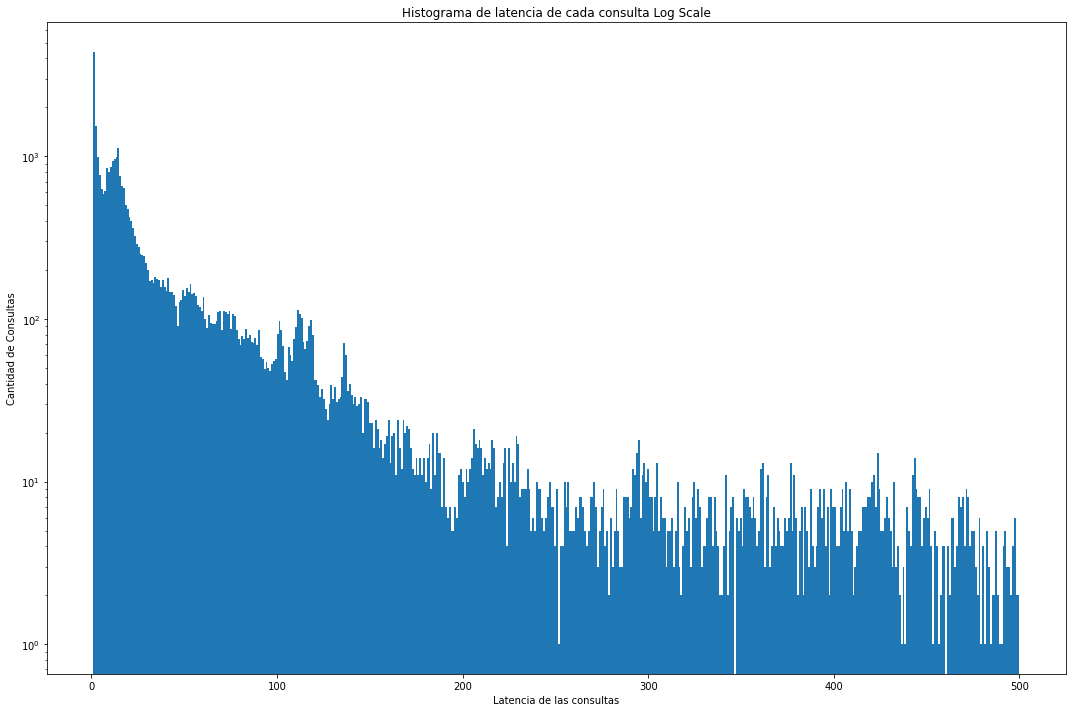

In [11]:
import matplotlib.pyplot as plt
import numpy as np
df_time_analysis = df_raw['time'].copy()
df_time_analysis = df_time_analysis.to_numpy()

f,ax = plt.subplots(figsize=(15,10))

ax.hist(df_time_analysis, bins=500)
ax.set_title("Histograma de latencia de cada consulta Log Scale")
ax.set_xlabel("Latencia de las consultas")
ax.set_ylabel("Cantidad de Consultas")
ax.set_yscale('log')
plt.tight_layout()

In [12]:
print("mean", df_raw['time'].mean())
print("std", df_raw['time'].std())
print('df_raw.shape',df_raw.shape)
print("max", df_raw['time'].max())
print("df_raw.shape", df_raw.shape)
df_raw = df_raw[df_raw['time'] >= 15]
df_raw = df_raw[df_raw['time'] <= 80]
df_raw = df_raw.reset_index(drop=True)
print("CLEAN by TIME")
print("mean", df_raw['time'].mean())
print("std", df_raw['time'].std())
print("max", df_raw['time'].max())
print("df_raw.shape", df_raw.shape)

mean 50.24851903290723
std 81.34166919915214
df_raw.shape (35281, 65)
max 500
df_raw.shape (35281, 65)
CLEAN by TIME
mean 36.70586839607719
std 19.11786941153308
max 80
df_raw.shape (12644, 65)


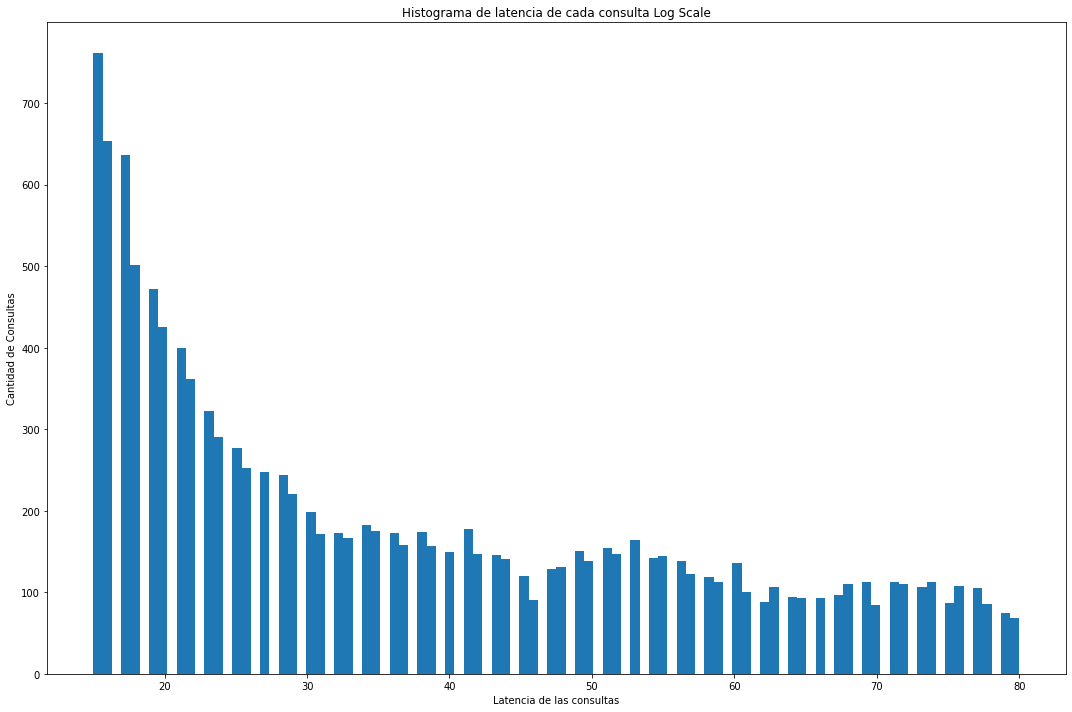

In [13]:
import matplotlib.pyplot as plt
import numpy as np
df_time_analysis2 = df_raw['time'].copy()
df_time_analysis2 = df_time_analysis2.to_numpy()

f,ax = plt.subplots(figsize=(15,10))

ax.hist(df_time_analysis2, bins=100)
ax.set_title("Histograma de latencia de cada consulta Log Scale")
ax.set_xlabel("Latencia de las consultas")
ax.set_ylabel("Cantidad de Consultas")
#ax.set_yscale('log')
plt.tight_layout()

In [14]:
if 'sparql_file' in df_raw.columns:
    df_raw = df_raw.rename(columns = {'sparql_file': 'query'}, inplace = False)
df_raw['cpu_p'] = df_raw['cpu_p'].apply(lambda x: float(x.strip('%')))
df_raw['same_seg_p'] = df_raw['same_seg_p'].apply(lambda x: float(x.strip('%')))
df_raw['same_page_p'] = df_raw['same_page_p'].apply(lambda x: float(x.strip('%')))
df_raw['wait'] = df_raw['wait'].apply(lambda x: float(x.strip('%')))
df_raw['comp_read_p'] = df_raw['comp_read_p'].apply(lambda x: float(x.strip('%')))
df_raw['comp_clw'] = df_raw['comp_clw'].apply(lambda x: float(x.strip('%')))

In [15]:
df_raw['time'].describe()

count    12644.000000
mean        36.705868
std         19.117869
min         15.000000
25%         20.000000
50%         31.000000
75%         52.000000
max         80.000000
Name: time, dtype: float64

In [16]:
ds_model, ds_rl_prev = split_ds(df_raw, 0.20,seed=None)
ds_model = ds_model.reset_index(drop=True)
ds_rl_prev = ds_rl_prev.reset_index(drop=True)
print("ds_model.shape",ds_model.shape)
print("ds_rl_prev.shape",ds_rl_prev.shape)

ds_model.shape (10113, 65)
ds_rl_prev.shape (2531, 65)


In [17]:
df_subtrees = subtree_format(ds_model)
df_subtrees['time'] = df_subtrees.time.astype(float)
print(ds_model.shape)
print(df_subtrees.shape)

(10113, 65)
(22759, 13)


In [18]:
df_subtrees['time'].describe()

count    22759.000000
mean        21.417776
std         22.481295
min          0.001020
25%          0.577070
50%         16.944751
75%         34.394950
max        100.275055
Name: time, dtype: float64

In [19]:
df_subtrees = df_subtrees[df_subtrees['time'] >= 1]
df_subtrees = df_subtrees[df_subtrees['time'] <= 75]
df_subtrees = df_subtrees.reset_index(drop=True)
df_subtrees['time'].describe()

count    15593.000000
mean        28.538715
std         19.567678
min          1.000200
25%         15.000000
50%         23.763960
75%         42.000000
max         75.000000
Name: time, dtype: float64

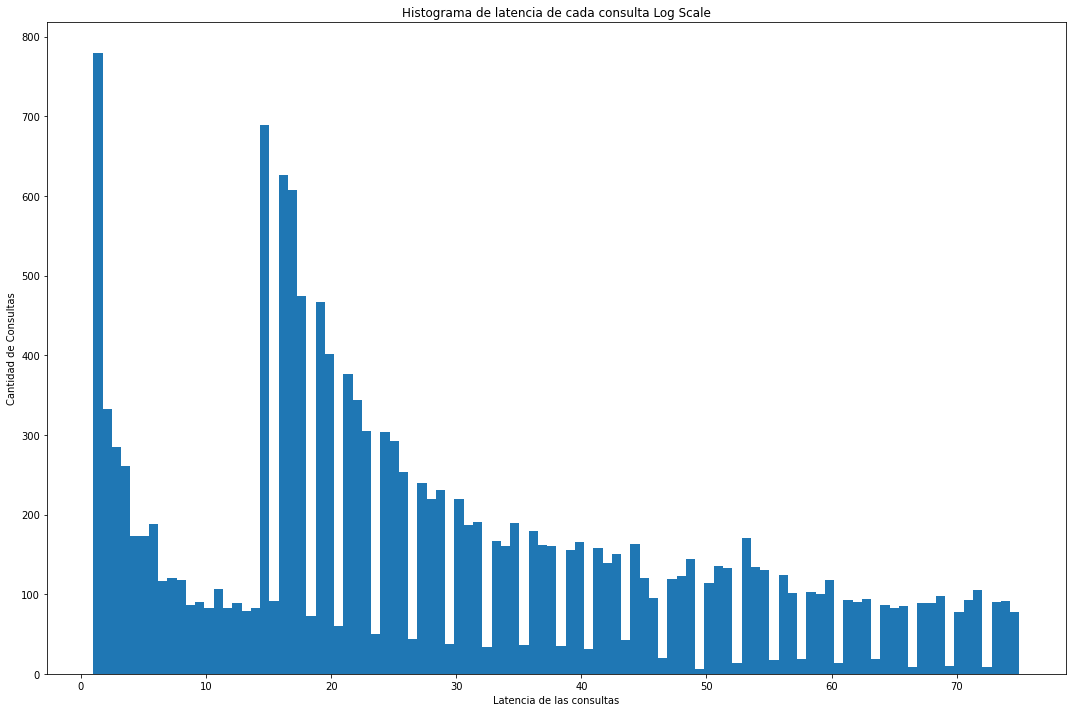

In [20]:
import matplotlib.pyplot as plt
import numpy as np
df_time_analysis3 = df_subtrees['time'].copy()
df_time_analysis3 = df_time_analysis3.to_numpy()

f,ax = plt.subplots(figsize=(15,10))

ax.hist(df_time_analysis3, bins=100)
ax.set_title("Histograma de latencia de cada consulta Log Scale")
ax.set_xlabel("Latencia de las consultas")
ax.set_ylabel("Cantidad de Consultas")
#ax.set_yscale('log')
plt.tight_layout()

In [21]:
ds_train_val_prev, ds_test_prev = split_ds(df_subtrees, 0.12,seed=None)
ds_train_prev, ds_val_prev = split_ds(ds_train_val_prev, 0.30,seed=None)
print("ds_train_val_prev.shape",ds_train_val_prev.shape)
print("ds_test_prev.shape",ds_test_prev.shape)
print("ds_train_prev.shape",ds_train_prev.shape)
print("ds_val_prev.shape",ds_val_prev.shape)
ds_train_prev = ds_train_prev.reset_index()
ds_val_prev = ds_val_prev.reset_index()
ds_test_prev = ds_test_prev.reset_index()
ds_rl_prev = ds_rl_prev.reset_index()

ds_train_val_prev.shape (13716, 13)
ds_test_prev.shape (1877, 13)
ds_train_prev.shape (9594, 13)
ds_val_prev.shape (4122, 13)


In [22]:
#Remove bad rows
ds_train  = ds_train_prev[ds_train_prev['trees'].apply(lambda x: clear_error_tuples(x))]
ds_val  = ds_val_prev[ds_val_prev['trees'].apply(lambda x: clear_error_tuples(x))]
ds_test  = ds_test_prev[ds_test_prev['trees'].apply(lambda x: clear_error_tuples(x))]
ds_rl = ds_rl_prev[ds_rl_prev['trees'].apply(lambda x: clear_error_tuples(x))]

print("---------SHAPES-----------")
print("----------RAW-----------")
print(f'shape df_raw: {df_raw.shape}')
print("----------PREV----------")
print(f'shape ds_train_val_prev: {ds_train_val_prev.shape}')
print(f'shape ds_train_prev: {ds_train_prev.shape}')
print(f'shape ds_val_prev: {ds_val_prev.shape}')
print(f'shape ds_test_prev: {ds_test_prev.shape}')
print(f'shape ds_rl_prev: {ds_rl_prev.shape}')
print("----------CLEAN----------")
print(f'shape ds_train: {ds_train.shape}')
print(f'shape ds_val: {ds_val.shape}')
print(f'shape ds_test: {ds_test.shape}')
print(f'shape ds_rl: {ds_rl.shape}')

---------SHAPES-----------
----------RAW-----------
shape df_raw: (12644, 65)
----------PREV----------
shape ds_train_val_prev: (13716, 13)
shape ds_train_prev: (9594, 14)
shape ds_val_prev: (4122, 14)
shape ds_test_prev: (1877, 14)
shape ds_rl_prev: (2531, 66)
----------CLEAN----------
shape ds_train: (9594, 14)
shape ds_val: (4122, 14)
shape ds_test: (1877, 14)
shape ds_rl: (2531, 66)


In [23]:
ds_train.to_csv(URL + csv_name + '_ds_train_ft.csv')
ds_val.to_csv(URL + csv_name + '_ds_val_ft.csv')
ds_test.to_csv(URL + csv_name + '_ds_test_ft.csv')
ds_rl.to_csv(URL + csv_name + '_ds_rl_ft.csv')